In [1]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [2]:
# Load the dataset
ratings_data = pd.read_csv('ratings.csv')

In [3]:
# Function to create bar chart for top rated movies
def create_bar_chart():
    top_rated_movies = ratings_data.groupby('movieId')['rating'].mean().sort_values(ascending=False).head(10)
    top_rated_movies.plot(kind='bar', color='lightgreen')
    plt.xlabel('Movie ID')
    plt.ylabel('Average Rating')
    plt.title('Top Rated Movies')
    plt.show()

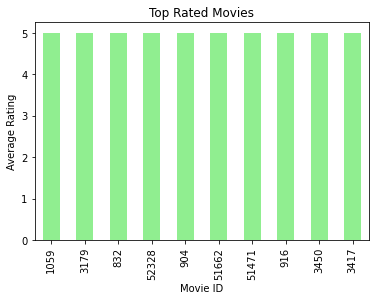

In [4]:
create_bar_chart()

In [5]:
# Function to create scatter plot for user ratings
def create_scatter_plot(user_id):
    user_ratings = ratings_data[ratings_data['userId'] == user_id]
    plt.scatter(user_ratings['movieId'], user_ratings['rating'], alpha=0.5)
    plt.xlabel('Movie ID')
    plt.ylabel('Rating')
    plt.title(f'Rating Distribution for User {user_id}')
    plt.show()

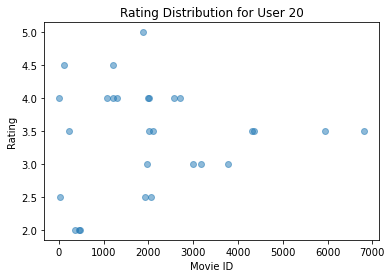

In [6]:
create_scatter_plot(20)

In [7]:
# Function to create multiple scatter plots for user ratings
def create_multiple_scatter_plots(user_ids):
    num_plots = len(user_ids)
    fig, axs = plt.subplots(num_plots, 1, figsize=(5, 5 * num_plots), squeeze=False)

    for i, user_id in enumerate(user_ids):
        user_ratings = ratings_data[ratings_data['userId'] == user_id]
        axs[i, 0].scatter(user_ratings['movieId'], user_ratings['rating'], alpha=0.5)
        axs[i, 0].set_xlabel('Movie ID')
        axs[i, 0].set_ylabel('Rating')
        axs[i, 0].set_title(f'Rating Distribution for User {user_id}')

    plt.tight_layout()
    plt.show()


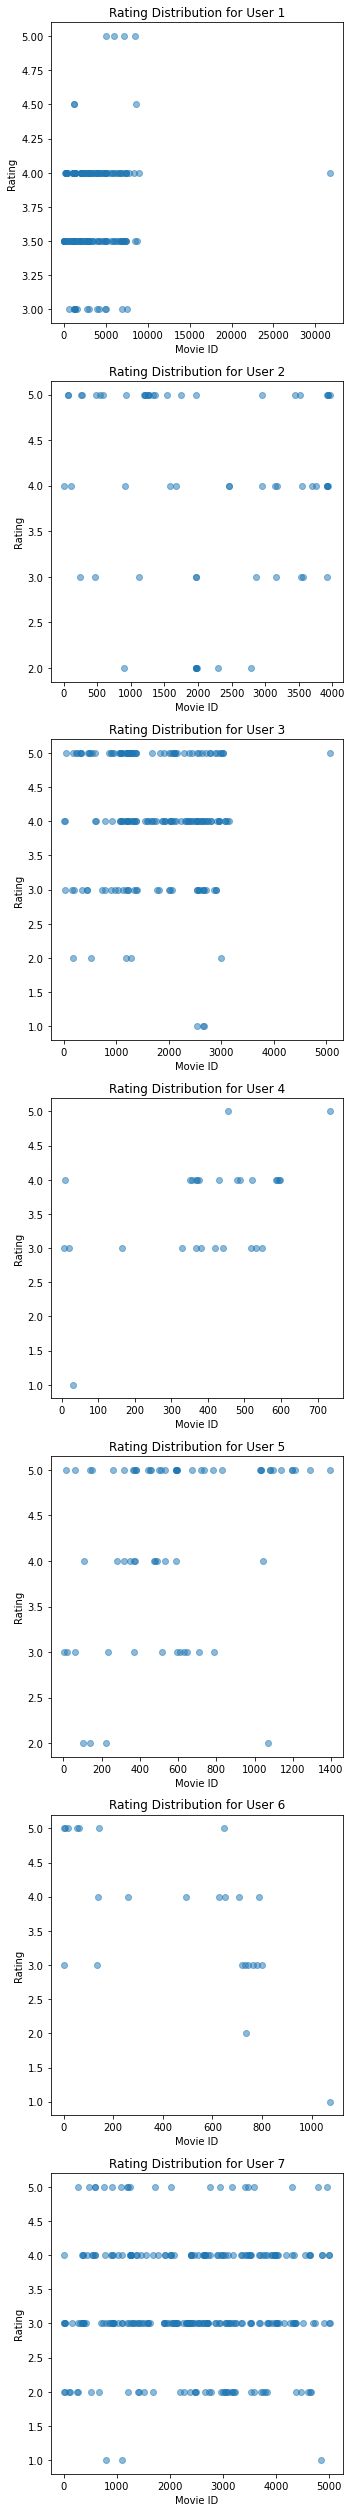

In [8]:
# Example usage
user_ids = [1, 2, 3, 4, 5, 6, 7]  # List of user IDs for which you want to create scatter plots
create_multiple_scatter_plots(user_ids)

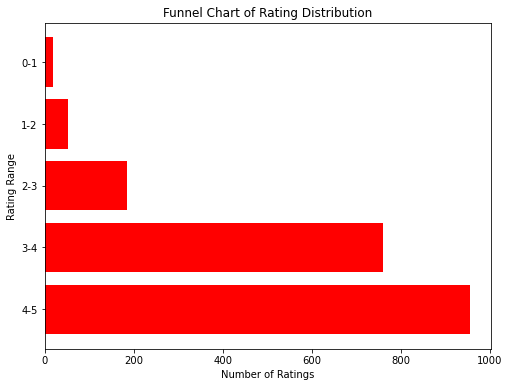

In [9]:
# Define rating ranges and count the number of ratings in each range
rating_ranges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]
rating_counts = [((ratings_data['rating'] >= start) & (ratings_data['rating'] < end)).sum() for start, end in rating_ranges]

# Plot the funnel chart
plt.figure(figsize=(8, 6))
plt.barh(range(len(rating_ranges)), rating_counts, color='red')
plt.yticks(range(len(rating_ranges)), [f'{start}-{end}' for start, end in rating_ranges])
plt.xlabel('Number of Ratings')
plt.ylabel('Rating Range')
plt.title('Funnel Chart of Rating Distribution')
plt.gca().invert_yaxis()  # Invert y-axis to display top-to-bottom
plt.show()


In [10]:
# Create a user-item matrix
user_item_matrix = ratings_data.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

In [11]:
# Calculate the cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)

In [12]:
# Function to get top N recommendations for a user
def get_top_n_recommendations(user_id, n=10):
    similarity_scores = user_similarity[user_id - 1]
    
    # Exclude the user's own similarity score
    similarity_scores[user_id - 1] = -1
    
    # Get indices of top N similar users
    top_n_similar_users_indices = similarity_scores.argsort()[-n:][::-1]
    
    # Get movies that the user hasn't rated
    user_ratings = user_item_matrix.loc[user_id]
    unrated_movies_indices = user_ratings[user_ratings == 0].index
    
    # Predict ratings for unrated movies by taking weighted average of ratings from similar users
    predicted_ratings = np.zeros(len(unrated_movies_indices))
    for movie_idx, movie_id in enumerate(unrated_movies_indices):
        similarity_sum = 0
        weighted_rating_sum = 0
        for similar_user_idx in top_n_similar_users_indices:
            if user_item_matrix.loc[similar_user_idx + 1, movie_id] != 0:
                similarity = user_similarity[user_id - 1, similar_user_idx]
                similarity_sum += similarity
                weighted_rating_sum += similarity * user_item_matrix.loc[similar_user_idx + 1, movie_id]
        if similarity_sum != 0:
            predicted_ratings[movie_idx] = weighted_rating_sum / similarity_sum
    
    # Get top N recommendations
    top_n_recommendations_indices = predicted_ratings.argsort()[-n:][::-1]
    top_n_recommendations = [(movie_id, predicted_ratings[idx]) for idx, movie_id in enumerate(unrated_movies_indices) if idx in top_n_recommendations_indices]
    
    return top_n_recommendations

In [14]:
# Tkinter app
class MovieRecommendationApp:
    def __init__(self, master):
        self.master = master
        master.title("Movie Recommendation System")

        self.label = tk.Label(master, text="Enter User ID:")
        self.label.pack()

        self.user_id_entry = tk.Entry(master)
        self.user_id_entry.pack()

        self.recommend_button = tk.Button(master, text="Get Recommendations", command=self.get_recommendations)
        self.recommend_button.pack()

    def get_recommendations(self):
        try:
            user_id = int(self.user_id_entry.get())
            recommendations = get_top_n_recommendations(user_id)
            messagebox.showinfo("Recommendations", f"Top 10 recommendations for user {user_id}:\n\n" +
                                "\n".join([f"{movie_id}: {estimated_rating}" for movie_id, estimated_rating in recommendations]))
        except ValueError:
            messagebox.showerror("Error", "Please enter a valid user ID.")

root = tk.Tk()
app = MovieRecommendationApp(root)
root.mainloop()